In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-16 15:17:29 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [2]:
thetadata_start = '2021-01-01'

In [3]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 10
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# ttrades__ = ttrades__[ttrades__.Duration>0]
ttrades__#.Ticker.unique()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,120,504,551,103.049417,100.110001,-352.730021,-0.028524,2023-01-04,2023-03-14,69,SBUX
1,11,504,675,195.863123,213.759995,196.865590,0.091374,2023-01-04,2023-09-11,250,BA
2,953,514,752,17.095625,49.813000,31179.657832,1.913786,2023-01-19,2023-12-29,344,NVDA
3,19,517,539,358.781354,319.299988,-750.145954,-0.110043,2023-01-24,2023-02-24,31,NFLX
4,28,521,752,149.932939,358.989990,5853.597444,1.394337,2023-01-30,2023-12-29,333,META
5,149,524,683,84.585016,98.599998,2088.232401,0.165691,2023-02-02,2023-09-21,231,AMD
6,70,525,540,148.548104,147.710007,-58.666794,-0.005642,2023-02-03,2023-02-27,24,AAPL
7,67,545,708,154.328258,170.369995,1074.796369,0.103946,2023-03-06,2023-10-26,234,AAPL
8,18,567,577,346.508538,320.390015,-470.133416,-0.075376,2023-04-05,2023-04-20,15,NFLX
9,110,575,587,109.251048,104.269997,-547.915622,-0.045593,2023-04-18,2023-05-04,16,SBUX


In [4]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,120,504,551,103.049417,100.110001,-352.730021,-0.028524,2023-01-04,2023-03-14,69,SBUX
1,11,504,675,195.863123,213.759995,196.865590,0.091374,2023-01-04,2023-09-11,250,BA
2,953,514,752,17.095625,49.813000,31179.657832,1.913786,2023-01-19,2023-12-29,344,NVDA
3,19,517,539,358.781354,319.299988,-750.145954,-0.110043,2023-01-24,2023-02-24,31,NFLX
4,28,521,752,149.932939,358.989990,5853.597444,1.394337,2023-01-30,2023-12-29,333,META
5,149,524,683,84.585016,98.599998,2088.232401,0.165691,2023-02-02,2023-09-21,231,AMD
6,70,525,540,148.548104,147.710007,-58.666794,-0.005642,2023-02-03,2023-02-27,24,AAPL
7,67,545,708,154.328258,170.369995,1074.796369,0.103946,2023-03-06,2023-10-26,234,AAPL
8,18,567,577,346.508538,320.390015,-470.133416,-0.075376,2023-04-05,2023-04-20,15,NFLX
9,110,575,587,109.251048,104.269997,-547.915622,-0.045593,2023-04-18,2023-05-04,16,SBUX


In [5]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
pd.Series(weights).sort_values(ascending=False)

NVDA    0.179689
AMD     0.139020
SBUX    0.136507
AAPL    0.115689
TSLA    0.115665
COST    0.090913
NFLX    0.077419
AMZN    0.073074
META    0.046265
BA      0.025760
dtype: float64

In [6]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .50,
   'dte': 210,
   'moneyness_width': 0.5},
  #  {'direction': 'short',
  # 'rel_strike': .60,
  # 'dte': 270,
  # 'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

Saving to cache from db


{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250321C280'],
  'trade_id': '&L:TSM20250321C280',
  'close': 1.515}}

In [7]:
max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash

{'NVDA': 2,
 'AMD': 2,
 'TSLA': 2,
 'AAPL': 2,
 'SBUX': 2,
 'NFLX': 2,
 'AMZN': 2,
 'COST': 2,
 'META': 2,
 'BA': 2}

In [54]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)

In [55]:
evb_backtest.portfolio.initial_capital

20000.0

In [56]:
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 25
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 365,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 365,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.roll_map
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.dte_reduction_factor = 60


In [57]:
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

In [58]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15
signals = evb_backtest.bars.signal_df
# series = signals.set_index('Date')['MSFT']
# series[series != 0]
signals

,Date,SBUX,BA,NVDA,NFLX,META,AMD,AAPL,AMZN,TSLA,COST
0,2023-01-04,1,1,0,0,0,0,0,0,0,0
1,2023-01-05,0,0,0,0,0,0,0,0,0,0
2,2023-01-06,0,0,0,0,0,0,0,0,0,0
3,2023-01-09,0,0,0,0,0,0,0,0,0,0
4,2023-01-10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
253,2023-12-25,0,0,0,0,0,0,0,0,0,0
254,2023-12-26,0,0,0,0,0,0,0,0,0,0
255,2023-12-27,0,0,0,0,0,0,0,0,0,0
256,2023-12-28,0,0,0,0,0,0,0,0,0,0


In [59]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

21.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [60]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['SBUX20240119C115'], 'short': ['SBUX20240119C120'], 'trade_id': '&L:SBUX20240119C115&S:SBUX20240119C120', 'close': 1.8000000000000007}, Date: 2023-01-04, Signal: SignalEvent type:LONG, symbol=SBUX, date:2023-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:SBUX20230104LONG
Max Contract Price: 2, Cash at Hand: 20.88553199782585
Cash at Hand 20.88553199782585 Close 1.8000000000000007
Processing event: SIGNAL
Buy Details
Position: {'long': ['BA20240119C310'], 'short': ['BA20240119C330'], 'trade_id': '&L:BA20240119C310&S:BA20240119C330', 'close': 2.0}, Date: 2023-01-04, Signal: SignalEvent type:LONG, symbol=BA, date:2023-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:BA20230104LONG
Max Contract Price: 2, Cash at Hand: 3.94131184479164
Cash at Hand 3.94131184479164 Close 2.0
Processing event: ORDER
Buy Order Position: {'long': ['SBUX20240119C115'], 'short': ['SBU

In [42]:
pd.set_option('display.max_rows', 100)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='NVDA']

,datetime,symbol,direction,cash_before,cash_after
2,2023-01-19,NVDA,BUY,3054.712245,313.962679
18,2023-09-12,NVDA,SELL,313.962679,6764.574966
19,2023-09-12,NVDA,BUY,6764.574966,689.418102
32,2023-12-29,NVDA,SELL,689.418102,4784.021438


In [16]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2023-04-28 00:00:00 1.9366987629213572 9.618493814606786
Sell
2023-10-26 00:00:00 2.8927857108775563 14.52892855438778 38


In [17]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x141dbe490>,
  <EventDriven.event.FillEvent at 0x142e0f7d0>])

In [44]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]
trades[['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue
0,BA20230104LONG,BA,-1.002116,&L:BA20230915C230&S:BA20230915C235,2023-01-04,2023-09-11,172.770396,-0.365547,342.940791,1.868906
1,SBUX20230104LONG,SBUX,-0.292124,&L:SBUX20230915C105&S:SBUX20230915C110,2023-01-04,2023-03-14,250.122070,177.055437,1990.576556,1426.843499
2,NVDA20230119LONG,NVDA,1.353594,&L:NVDA20230915C180&S:NVDA20230915C185,2023-01-19,2023-09-12,210.826890,496.200945,2723.849566,6467.512287
3,NFLX20230124LONG,NFLX,-0.588621,&L:NFLX20240119C650&S:NFLX20240119C700,2023-01-24,2023-02-24,200.116449,82.323705,994.082243,418.118527
4,META20230130LONG,META,1.350920,&L:META20231117C160&S:META20231117C165,2023-01-30,2023-11-14,216.046263,507.907480,644.238788,1527.622441
5,AMD20230202LONG,AMD,-0.751450,&L:AMD20240119C150&S:AMD20240119C200,2023-02-02,2023-09-21,195.609555,48.618808,1943.095551,499.188079
6,AAPL20230203LONG,AAPL,-0.422251,&L:AAPL20231215C200&S:AAPL20231215C220,2023-02-03,2023-02-27,201.375632,116.344524,1600.605052,941.156195
7,AAPL20230306LONG,AAPL,0.044999,&L:AAPL20231215C170&S:AAPL20231215C175,2023-03-06,2023-10-26,204.618830,213.826379,1016.594148,1075.631893
8,NFLX20230405LONG,NFLX,-0.399804,&L:NFLX20240119C465&S:NFLX20240119C475,2023-04-05,2023-04-20,192.010558,115.243881,572.131674,349.631643
9,SBUX20230418LONG,SBUX,-0.294497,&L:SBUX20240119C125&S:SBUX20240119C135,2023-04-18,2023-05-04,207.445484,146.353505,1443.018390,1033.574532


<Axes: xlabel='datetime'>

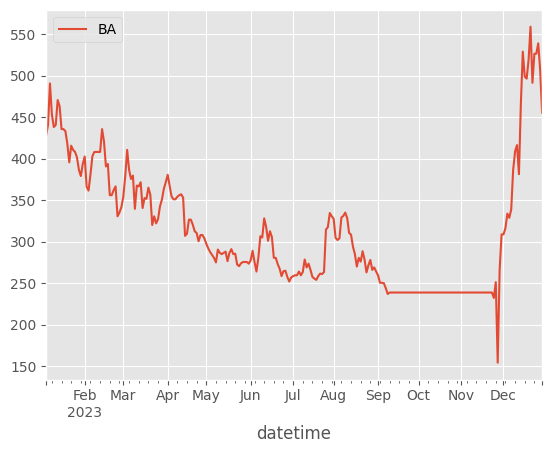

In [63]:
evb_backtest.portfolio._equity.plot(y = 'BA')

In [19]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{'type': 'SIGNAL', 'symbol': 'NFLX', 'datetime': Timestamp('2023-05-23 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'NFLX20230523LONG', 'max_contract_price': None, 'order_settings': {'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.85, 'dte': 300, 'moneyness_width': 0.65}, {'direction': 'short', 'rel_strike': 0.6, 'dte': 300, 'moneyness_width': 0.65}], 'name': 'vertical_spread'}, 'reason': 'MONEYNESS_TOO_TIGHT'}
{'type': 'SIGNAL', 'symbol': 'COST', 'datetime': Timestamp('2023-07-03 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'COST20230703LONG', 'max_contract_price': 14.860167413759998, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'NFLX', 'datetime': Timestamp('2023-11-06 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'NFLX20231106LONG', 'max_contract_price': 4.1472, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'BA', 'datetime': Timestamp('2023-11-24 00:00:00'), 'signal_type': 'LONG

{'MONEYNESS_TOO_TIGHT': 1, 'MAX_PRICE_TOO_LOW': 3}

In [61]:
evb_backtest.portfolio.plot_portfolio()

In [22]:
evb_backtest.portfolio.aggregate()

Start                                                    2023-01-04 00:00:00
End                                                      2023-12-29 00:00:00
Duration                                                   359 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    18554.52
Equity Peak [$]                                                 31095.957003
Return [%]                                                         -6.800953
Buy & Hold Return [%]                                              65.155095
CAGR [%]                                                           -6.910598
Volatility Ann. [%]                                                 67.02801
Sharpe Ratio                                                        0.227035
Sortino Ratio                                                       0.344565
Skew                                                                0.071637

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-01-04,2.20,2.20,2.20,2.20,8,-8,1.60,-71,1.75,1.675,1.588402
2023-09-11,-0.05,-0.02,0.01,0.01,1068,14,0.01,20,0.01,0.010,0.010832


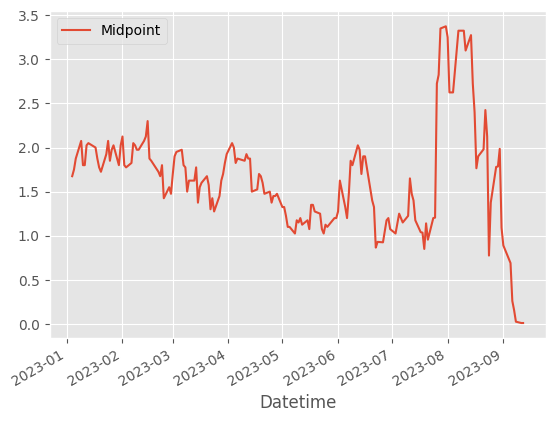

In [47]:
#&L:COST20230120C680&S:COST20230120C700
# 9	2022-01-11	COST	BUY	989.300187	165.485214
# 12	2022-01-21	COST	SELL	165.485214	33.494091
# &L:BA20230915C230&S:BA20230915C235	2023-01-04	2023-09-11	
# &L:NVDA20240621C710&S:NVDA20240621C730	2023-09-12	2023-12-29
# &L:NVDA20230915C180&S:NVDA20230915C185	2023-01-19	2023-09-12
# &L:AMD20240119C150&S:AMD20240119C200	2023-02-02	2023-09-21
price_data = evb_backtest.portfolio.options_data['BA20230915C230'] - evb_backtest.portfolio.options_data['BA20230915C235']
price_data[price_data.index <= '2023-09-12'].plot(y = 'Midpoint')#[(price_data.index >= '2022-01-11') & (price_data.index <= '2022-01-31')]
price_data[price_data.index.isin(['2023-01-04', '2023-09-11'])]

In [53]:
st_price = Stock('BA').spot(ts = True, ts_start = '2023-01-01', ts_end = '2023-09-11')
st_price[st_price.index.isin(['2023-01-04', '2023-09-11'])][['close']]

,close
date,
2023-01-04,203.639999
2023-09-11,211.009995


In [63]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                             
2022-01-04 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-05 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-06 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-07 AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-10 AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-11 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-12 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-13 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-14 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-17 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-18 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-19 COST     [COST20230120C680]   [COST20230120C700]   
2022-01-20 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-21 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-24 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-25 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-26 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-27 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-28 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-31 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-02-01 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-02 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-03 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-04 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-07 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
20

In [64]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [65]:
order_cache['2024-01-03']

KeyError: '2024-01-03'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [89]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'